 Ce script applique les données du DCU à un modèle LSTM . 


In [90]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import argparse
import copy

import numpy as np
import pandas as pd

import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


from data_handler import DataHandler


In [91]:

from keras.layers import Activation, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import CSVLogger



def embeding(df):
    df_copy = copy.deepcopy(df)
    for header, values in df_copy.items():
        df_copy[header] = pd.Categorical(df_copy[header])
        df_copy[header] = df_copy[header].cat.codes
    return df_copy

def DA_Jitter(X, sigma):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

def data_augmentation(data_arr,sigma):
    newData_arr = data_arr[:,1:8]
    newData_arr = DA_Jitter(newData_arr, sigma)

    newData_arr = np.column_stack((data_arr[:,0],newData_arr,data_arr[:,8]))
    newData_arr = newData_arr[newData_arr[:,-1] != 1]
    return  newData_arr

In [92]:
# parse arguments
## general
arg_parser = argparse.ArgumentParser()
arg_parser.add_argument('--working_path', default='.')

## data
arg_parser.add_argument('dataset_name', default='mimic3',
                        help='The data files should be saved in [working_path]/data/[dataset_name] directory.')
arg_parser.add_argument('label_name', default='mortality')
arg_parser.add_argument('--max_timesteps', type=int, default=200, 
                        help='Time series of at most # time steps are used. Default: 200.')
arg_parser.add_argument('--max_timestamp', type=int, default=48*60*60,
                        help='Time series of at most # seconds are used. Default: 48 (hours).')

## model
arg_parser.add_argument('--recurrent_dim', type=lambda x: x and [int(xx) for xx in x.split(',')] or [], default='64')
arg_parser.add_argument('--hidden_dim', type=lambda x: x and [int(xx) for xx in x.split(',')] or [], default='64')
arg_parser.add_argument('--model', default='GRUD', choices=['GRUD', 'GRUforward', 'GRU0', 'GRUsimple'])
arg_parser.add_argument('--use_bidirectional_rnn', default=False)
                           
## training
arg_parser.add_argument('--pretrained_model_file', default=None,
                        help='If pre-trained model is provided, training will be skipped.') # e.g., [model_name]_[i_fold].h5
arg_parser.add_argument('--epochs', type=int, default=100)
arg_parser.add_argument('--early_stopping_patience', type=int, default=10)
arg_parser.add_argument('--batch_size', type=int, default=2)


## set the actual arguments if running in notebook
if not (__name__ == '__main__' and '__file__' in globals()):
    # '''ARGS = arg_parser.parse_args([
    #     'mimic3',
    #     'mortality',
    #     '--model', 'GRUD',
    #     '--hidden_dim', '',
    #     '--epochs', '100'
    # ])'''
    ARGS = arg_parser.parse_args([
        'detection',
        'risk_situation',
        '--model', 'GRUD',
        '--hidden_dim', '',
        '--max_timestamp', '5807537',
        '--epochs', '100'
    ])
else:
    ARGS = arg_parser.parse_args()

#print('Arguments:', ARGS)

In [93]:
# get dataset
dataset = DataHandler(
    data_path=os.path.join(ARGS.working_path, 'data', ARGS.dataset_name), 
    label_name=ARGS.label_name, 
    max_steps=ARGS.max_timesteps,
    max_timestamp=ARGS.max_timestamp
)

### Embeding

In [94]:
sigma = 0.05

data = pd.DataFrame(dataset._data['input'])
data = embeding(data)

##on enleve fall et timestamp et fusion des classes
df = pd.DataFrame(data)
df.columns = ["timestamp","name", "latitude", "longitude", "step","gsr","heart_rate","skin_temp","calories","risk_situation"]
df.pop("timestamp")

df = df[df.risk_situation != -1]
df = df[df.risk_situation != 0]
df = df[df.risk_situation != 3]

df.loc[df.risk_situation == 4 , 'risk_situation'] = 0
df.loc[df.risk_situation == 2 , 'risk_situation'] = 0
# df = df[pd.notnull(df['risk_situation'])]

to_remove = np.random.choice(df[df['risk_situation']==1].index,size=15000,replace=False)
df=df.drop(to_remove)
stat = df['risk_situation'].value_counts(dropna=False)
print(stat)
df.head(30)

1    6152
0     526
Name: risk_situation, dtype: int64


,name,latitude,longitude,step,gsr,heart_rate,skin_temp,calories,risk_situation
368,33,-1,-1,0,1468,109,16,36,1
369,33,-1,-1,0,1490,113,16,44,1
375,33,-1,-1,0,1539,114,16,41,0
377,33,-1,-1,0,1495,4,16,56,0
378,33,-1,-1,0,1478,7,16,59,0
380,33,-1,-1,0,1451,118,15,44,0
381,33,-1,-1,0,1468,5,15,58,0
382,33,-1,-1,0,1465,112,15,37,1
392,33,-1,-1,0,-1,-1,-1,9,1
395,33,-1,-1,0,-1,-1,-1,9,1


In [95]:
targets = df.pop('risk_situation')

In [96]:
targets.shape

(6678,)

In [97]:
from keras.utils import to_categorical
# targets = to_categorical(targets,2)

print(targets.shape)


X_train, X_val, y_train, y_val = train_test_split(df.values,
                targets, test_size=0.2, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_train,
                y_train, test_size=0.125, random_state=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(6678,)
(4674, 8) (4674,)
(1336, 8) (1336,)
(668, 8) (668,)


### Data augmentation

1    4291
0     383
Name: 8, dtype: int64
1.0    4291
0.0    3064
Name: 8, dtype: int64


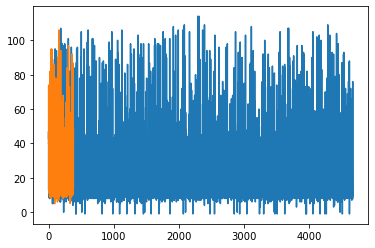

In [98]:
train = np.column_stack((X_train,y_train))

stat = pd.DataFrame(train)[8].value_counts(dropna=False)
print(stat)

newData_arr = data_augmentation(train, 0.05)
X_train = np.concatenate((X_train,newData_arr[:,:8]))
y_train = np.concatenate((y_train,newData_arr[:,8]))

pd.DataFrame(train)[7].plot()
pd.DataFrame(newData_arr)[7].plot()


newData_arr = data_augmentation(train, 0.04)
X_train = np.concatenate((X_train,newData_arr[:,:8]))
y_train = np.concatenate((y_train,newData_arr[:,8]))

newData_arr = data_augmentation(train, 0.06)
X_train = np.concatenate((X_train,newData_arr[:,:8]))
y_train = np.concatenate((y_train,newData_arr[:,8]))

newData_arr = data_augmentation(train, 0.055)
X_train = np.concatenate((X_train,newData_arr[:,:8]))
y_train = np.concatenate((y_train,newData_arr[:,8]))

newData_arr = data_augmentation(train, 0.045)
X_train = np.concatenate((X_train,newData_arr[:,:8]))
y_train = np.concatenate((y_train,newData_arr[:,8]))

newData_arr = data_augmentation(train, 0.03)
X_train = np.concatenate((X_train,newData_arr[:,:8]))
y_train = np.concatenate((y_train,newData_arr[:,8]))

newData_arr = data_augmentation(train, 0.07)
X_train = np.concatenate((X_train,newData_arr[:,:8]))
y_train = np.concatenate((y_train,newData_arr[:,8]))


train = np.column_stack((X_train,y_train))
stat = pd.DataFrame(train)[8].value_counts(dropna=False)
print(stat)


In [99]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

7355 train sequences
668 test sequences


In [100]:
print('Pad sequences (samples x time)')
#X_train = sequence.pad_sequences(X_train[:200], maxlen=maxlen)
#X_test = sequence.pad_sequences(X_test[:200], maxlen=maxlen)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)



Pad sequences (samples x time)
x_train shape: (7355, 8)
x_test shape: (668, 8)


In [101]:
#X = X_train.reshape(len(X_train),3,3)
#y = y_train.values.reshape(len(y_train), 1)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
# trainY = np.reshape(y_train, (y_train.shape[0], 1, 1))
# testY = np.reshape(y_test, (y_test.shape[0], 1, 1))

In [102]:
print(trainX.shape, y_train.shape, testX.shape, y_test.shape)

(7355, 1, 8) (7355,) (668, 1, 8) (668,)


In [103]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [104]:
from keras.optimizers import SGD
opt = SGD(lr=0.001)
# create and fit the LSTM network
print("Building model...")
model = Sequential()
model.add(LSTM(8, input_shape=(1, 8)))
model.add(Dense(1, activation='softmax'))

# model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer=opt,metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


## Training

In [105]:
print("Training...")
history = LossHistory()
csv_logger = CSVLogger('log_epoch.csv', append=False, separator=';')
h = model.fit(trainX, y_train, epochs=50, batch_size=200, verbose=2,callbacks=[csv_logger],validation_data=(X_val, y_val))

Training...
Train on 7355 samples, validate on 1336 samples
Epoch 1/50
 - 1s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 2/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 3/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 4/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 5/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 6/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 7/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 8/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 9/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 10/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 11/50
 - 0s - loss: 6.6414 - acc: 0.5834 - val_loss: 1.0262 - val_acc: 0.9356
Epoch 12/50
 - 0s - loss:

0.9356287425149701
0


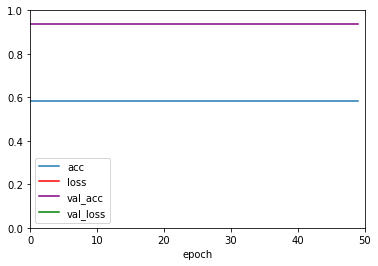

In [106]:
print(max(h.history['val_acc']))
print(h.history['val_acc'].index(max(h.history['val_acc'])))
      
log = pd.read_csv('log_epoch.csv',sep=';')
ax = plt.gca()

ax.set_ylim([0,1])
ax.set_xlim([0,50])

log.plot(kind='line',x='epoch',y='acc',ax=ax)
log.plot(kind='line',x='epoch',y='loss', color='red', ax=ax)

log.plot(kind='line',x='epoch',y='val_acc',color='purple',ax=ax)
log.plot(kind='line',x='epoch',y='val_loss', color='green', ax=ax)

plt.show()

In [107]:
from sklearn.metrics import classification_report

y_pred = model.predict_classes(testX)
y_test_rounded = np.argmax(y_test,axis=1)

# print(y_test)
# print(y_test)
# 
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        57
          1       0.91      1.00      0.96       611

avg / total       0.84      0.91      0.87       668



C:\Users\paulj\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\paulj\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[  0,  57],
       [  0, 611]], dtype=int64)